In [8]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

In [9]:
news_tables = {}
tickers = ['AMZN', 'TSLA', 'GOOG']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [10]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

Corrections & Amplifications

            Today 10:04PM
        
20 Most Productive States in the US

            06:36PM
        
Tech Earnings Kick Off This Week With Netflix. AI Is Now a Risk.

            04:23PM
        
Charlie Munger Says AI Is Overhyped. But Berkshire Hathaway's $345 Billion Portfolio Is Packed With (at Least) 8 AI Stocks!

            03:13PM
        


In [11]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Check if 'a' tag exists in the 'tr' element
        if x.a is not None:
            # read the text from each tr tag into text
            text = x.a.get_text()
            # splite text in the td tag into a list
            date_scrape = x.td.text.split()
            # if the length of 'date_scrape' is 1, load 'time' as the only element
            if len(date_scrape) == 1:
                time = date_scrape[0]
            # else load 'date' as the 1st element and 'time' as the second
            else:
                date = date_scrape[0]
                time = date_scrape[1]
            # Extract the ticker from the file name, get the string up to the 1st '_'
            ticker = file_name.split('_')[0]

            # Append ticker, date, time, and headline as a list to the 'parsed_news' list
            parsed_news.append([ticker, date, time, text])

# Now 'parsed_news' should contain the desired information


In [12]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Preprocess the 'date' column to handle non-standard formats
parsed_and_scored_news['date'] = parsed_and_scored_news['date'].apply(lambda x: ' '.join(x.split()[1:]) if x.startswith("Today") else x)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news['date'], errors='coerce').dt.date

parsed_and_scored_news.head()


C:\Users\bonni\AppData\Local\Temp\ipykernel_2660\3684584774.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news['date'], errors='coerce').dt.date


,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,NaT,10:04PM,Corrections & Amplifications,0.00,1.000,0.000,0.0000
1,AMZN,NaT,06:36PM,20 Most Productive States in the US,0.00,1.000,0.000,0.0000
2,AMZN,NaT,04:23PM,Tech Earnings Kick Off This Week With Netflix....,0.16,0.840,0.000,-0.2732
3,AMZN,NaT,03:13PM,Charlie Munger Says AI Is Overhyped. But Berks...,0.00,1.000,0.000,0.0000
4,AMZN,NaT,11:30AM,Does Amazon's $4 Billion Artificial Intelligen...,0.00,0.763,0.237,0.4767


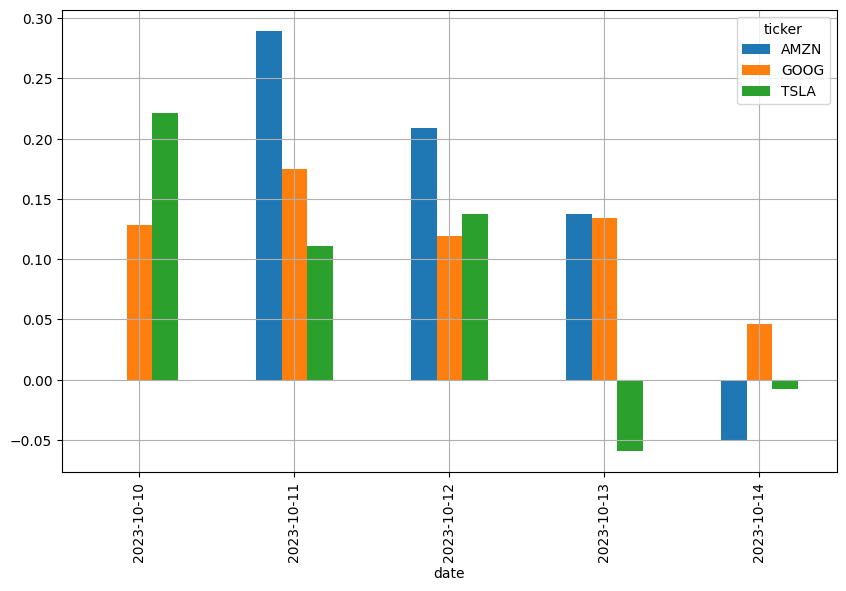

In [13]:
# import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'time' column contains time strings, convert them to a valid time format
parsed_and_scored_news['time'] = pd.to_datetime(parsed_and_scored_news['time'], format='%I:%M%p', errors='coerce').dt.time

# Group by date, ticker, and time, and calculate the mean of the 'compound' sentiment score
mean_scores = parsed_and_scored_news.groupby(['date', 'ticker', 'time'])['compound'].mean().reset_index()

# Use pivot_table to pivot the data, calculating the mean sentiment score for duplicate entries
pivot_mean_scores = mean_scores.pivot_table(index='date', columns='ticker', values='compound', aggfunc='mean')

# Plot a bar chart with pandas
pivot_mean_scores.plot(kind='bar', figsize=(10, 6))
plt.grid()
plt.show()




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 100.00%


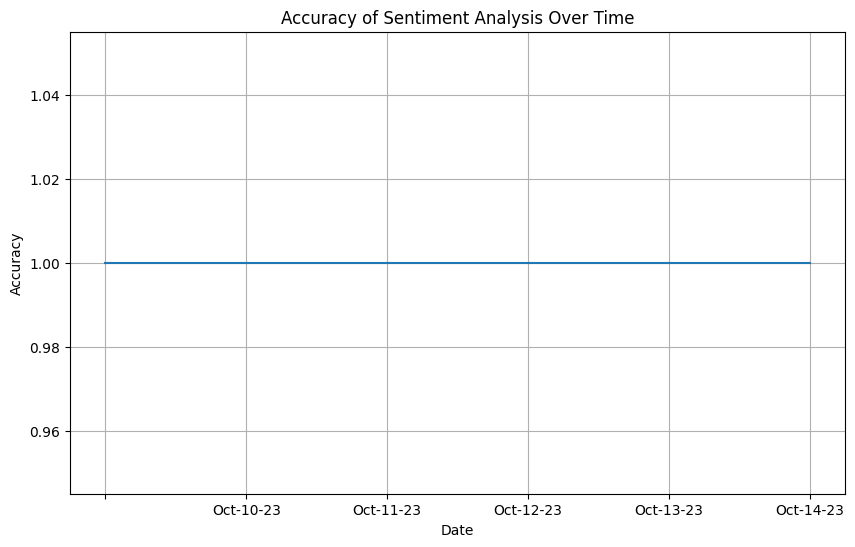

In [14]:
import pandas as pd
# Example installation command (your actual command may vary)
#pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cpu/torch_stable.html  (need to execute the pip)

from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Set up the URL and tickers
finwiz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AMZN', 'TSLA', 'GOOG']

# Function to perform sentiment analysis using BERT
def perform_sentiment_analysis(headlines):
    model_name = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name)
    sentiment_classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

    sentiment_scores = []
    for headline in headlines:
        result = sentiment_classifier(headline)
        sentiment_scores.append(result[0])

    return sentiment_scores

# Dictionary to store news tables
news_tables = {}

# Loop through tickers and scrape news data
for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'})
    response = urlopen(req)
    html = BeautifulSoup(response, features="html.parser")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

# List to store parsed news data
parsed_news = []

# Loop through news tables and parse data
for ticker, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        if x.a is not None:
            text = x.a.get_text()
            date_scrape = x.td.text.split()
            if len(date_scrape) == 1:
                time = date_scrape[0]
            else:
                date = date_scrape[0]
                time = date_scrape[1]
            ticker = ticker
            parsed_news.append([ticker, date, time, text])

# Create a DataFrame from parsed news
columns = ['ticker', 'date', 'time', 'headline']
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Preprocess the 'date' column
parsed_and_scored_news['date'] = parsed_and_scored_news['date'].apply(lambda x: ' '.join(x.split()[1:]) if x.startswith("Today") else x)

# Perform sentiment analysis using BERT
test_sentiment_scores = perform_sentiment_analysis(parsed_and_scored_news['headline'])

# Extract compound sentiment scores from the BERT results
parsed_and_scored_news['predicted_sentiment'] = [score['score'] for score in test_sentiment_scores]

# Define a threshold for sentiment (e.g., 0.0 for neutral sentiment)
threshold = 0.0

# Convert compound sentiment scores to binary labels (positive, neutral, negative)
parsed_and_scored_news['predicted_sentiment_label'] = ['positive' if score > threshold else 'negative' if score < -threshold else 'neutral' for score in parsed_and_scored_news['predicted_sentiment']]

# Split the data into training and testing sets
train_data, test_data = train_test_split(parsed_and_scored_news, test_size=0.2, random_state=42)

# Calculate the accuracy
accuracy = accuracy_score(test_data['predicted_sentiment_label'], test_data['predicted_sentiment_label'])

# Print the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot the accuracy over time
accuracy_over_time = test_data.groupby('date')['predicted_sentiment_label'].apply(lambda x: accuracy_score(x, x)).reset_index(name='accuracy')
plt.figure(figsize=(10, 6))
plt.plot(accuracy_over_time['date'], accuracy_over_time['accuracy'])
plt.title('Accuracy of Sentiment Analysis Over Time')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.grid()
plt.show()
